# The Packages

In [1]:
import numpy as np
import pandas as pd
import os
import gc
import datetime
import warnings

In [2]:

import statsmodels.api as sm
from datetime import date

In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [4]:
import tensorflow as tf
import math 
# keras = tf.keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM
from tensorflow.keras import losses
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.utils import plot_model

In [5]:
tf.__version__

'2.10.1'

In [6]:
# DATA VISUALIZATION
# ------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (20.0, 10.0)
sns.set_style("darkgrid")
sns.color_palette("mako", as_cmap=True)
import plotly.express as px


In [7]:
# CONFIGURATIONS
# ------------------------------------------------------
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format
warnings.filterwarnings('ignore')

# Utility Functions

In [8]:
def plotSeries(time, series, lab,form='-'):
    plt.plot(time, series, form, label=lab)
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.grid(True)

# The Data

In [9]:
wfc = pd.read_csv('Dataset/WFC Daily1.csv')

In [10]:
wfc.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-03,20.16,20.19,19.00,19.56,10.44,9037000
1,2000-01-04,18.62,18.84,18.00,18.59,9.92,15237200
2,2000-01-05,18.50,18.88,18.03,18.41,9.82,8228200
3,2000-01-06,18.53,19.50,18.47,19.22,10.25,8326800
4,2000-01-07,19.62,19.84,19.28,19.56,10.44,7711200


In [11]:
wfc.Date.dtype

dtype('O')

In [12]:
wfc['Date'] = pd.to_datetime(wfc['Date'])
#wfc.set_index(['Date'],inplace=True)

In [13]:
wfc.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-03,20.16,20.19,19.00,19.56,10.44,9037000
1,2000-01-04,18.62,18.84,18.00,18.59,9.92,15237200
2,2000-01-05,18.50,18.88,18.03,18.41,9.82,8228200
3,2000-01-06,18.53,19.50,18.47,19.22,10.25,8326800
4,2000-01-07,19.62,19.84,19.28,19.56,10.44,7711200


In [14]:
wfc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5754 entries, 0 to 5753
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       5754 non-null   datetime64[ns]
 1   Open       5754 non-null   float64       
 2   High       5754 non-null   float64       
 3   Low        5754 non-null   float64       
 4   Close      5754 non-null   float64       
 5   Adj Close  5754 non-null   float64       
 6   Volume     5754 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 314.8 KB


In [15]:
wfc.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5754.00,5754.00,5754.00,5754.00,5754.00,5754.00
mean,36.38,36.78,35.98,36.38,28.01,24313450.19
std,11.74,11.77,11.73,11.75,12.85,26705062.78
min,8.65,8.94,7.80,8.12,5.76,1774000.00
25%,26.71,27.20,26.25,26.74,18.01,10091200.00
50%,32.65,33.13,32.25,32.64,23.18,17086600.00
75%,47.75,48.19,47.33,47.79,41.58,29145250.00
max,65.89,66.31,65.66,65.93,57.96,478736600.00


In [16]:
correlation = wfc.corr ()  
correlation. style.background_gradient ()

,Open,High,Low,Close,Adj Close,Volume
Open,1.000000,0.999324,0.999274,0.998754,0.965403,-0.184389
High,0.999324,1.000000,0.998796,0.999323,0.967945,-0.169457
Low,0.999274,0.998796,1.000000,0.999303,0.963519,-0.199335
Close,0.998754,0.999323,0.999303,1.000000,0.966149,-0.183272
Adj Close,0.965403,0.967945,0.963519,0.966149,1.000000,-0.080189
Volume,-0.184389,-0.169457,-0.199335,-0.183272,-0.080189,1.000000


# The Split

In [17]:
min_date = wfc.Date.min()
max_date = wfc.Date.max()
print("Min:", min_date, "Max:", max_date)

Min: 2000-01-03 00:00:00 Max: 2022-11-11 00:00:00


In [18]:
train_percent = .75
valid_percent = .12

time_between = max_date - min_date

train_cutoff = min_date + train_percent*time_between
valid_cutoff = min_date + (train_percent + valid_percent)*time_between

print("Training Cutoff Date: {:s}".format(str(train_cutoff)))
print("Validation Cutoff Date: {:s}".format(str(valid_cutoff)))

Training Cutoff Date: 2017-02-23 00:00:00
Validation Cutoff Date: 2019-11-21 18:14:24


In [19]:
train_df = wfc[wfc.Date <= train_cutoff]
valid_df = wfc[(wfc.Date > train_cutoff) & (wfc.Date <= valid_cutoff)]
test_df = wfc[wfc.Date > valid_cutoff]


In [20]:
print("Dataset shape: {:s}".format(str(wfc.shape)))
print("Train dataset shape: {:s}".format(str(train_df.shape)))
print("Vaid dataset shape: {:s}".format(str(valid_df.shape)))
print("Test dataset shape: {:s}".format(str(test_df.shape)))

Dataset shape: (5754, 7)
Train dataset shape: (4313, 7)
Vaid dataset shape: (692, 7)
Test dataset shape: (749, 7)


# Stock Price Graph

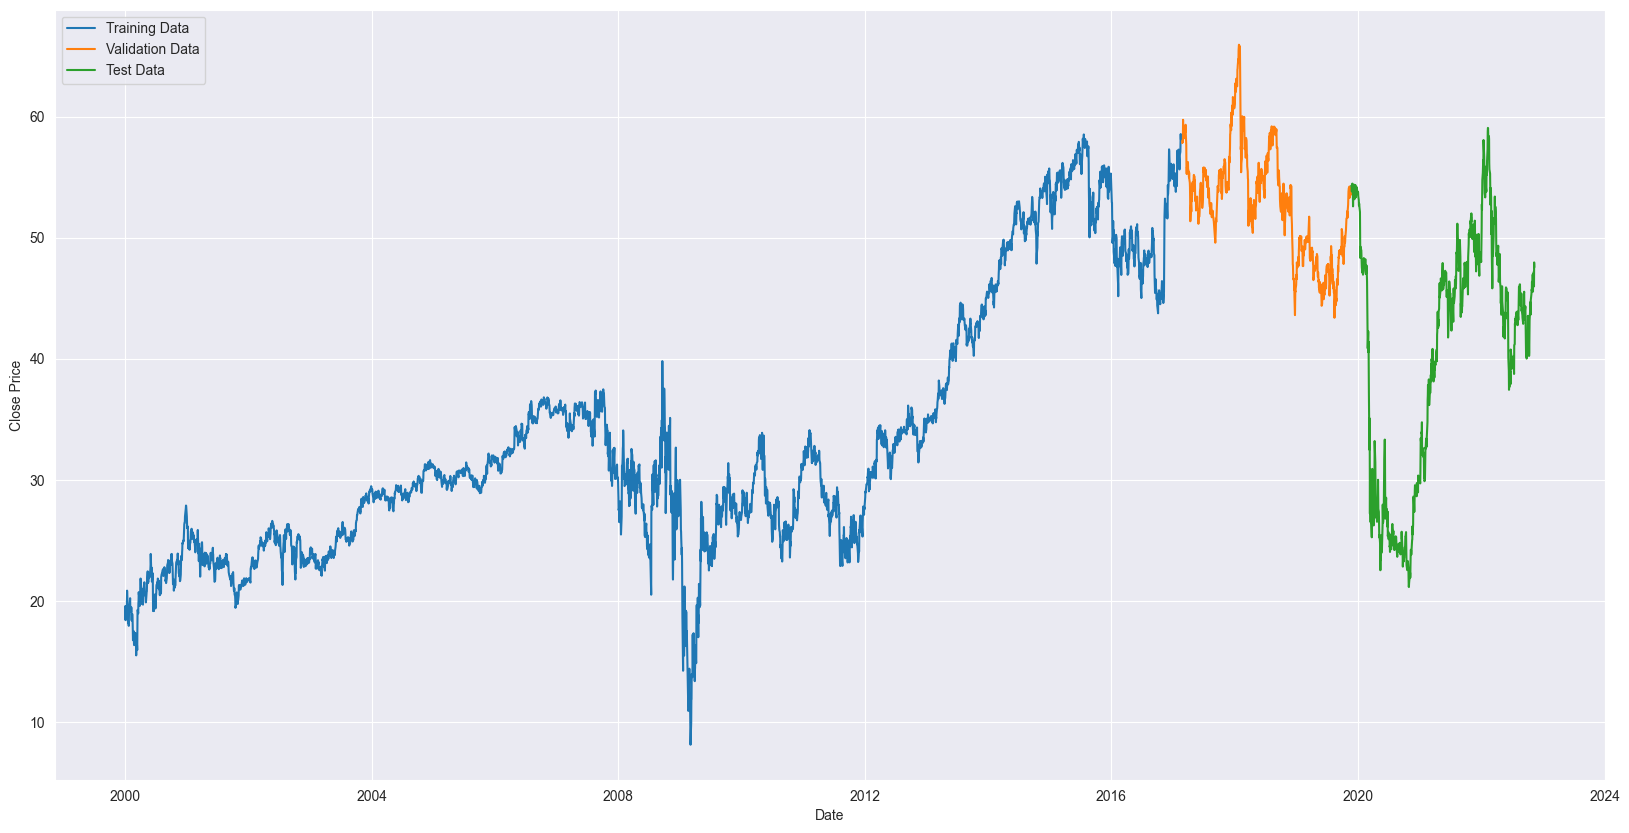

In [21]:
plotSeries(train_df.Date, train_df.Close, "Training Data")
plotSeries(valid_df.Date, valid_df.Close, "Validation Data")
plotSeries(test_df.Date, test_df.Close, "Test Data")
plt.legend(loc='upper left')

In [22]:
# How to add the Date columns after normalizing
# Maybe do TCS & infosys for better smoothing 

In [23]:
train_df.set_index(['Date'],inplace=True)
test_df.set_index(['Date'],inplace=True)
valid_df.set_index(['Date'],inplace=True)

In [24]:
scaler = MinMaxScaler()

trainNorm = scaler.fit_transform(train_df.Close.values.reshape(-1, 1))
testNorm = scaler.transform(test_df.Close.values.reshape(-1, 1))
validNorm = scaler.transform(valid_df.Close.values.reshape(-1, 1))

In [25]:
trainNorm.shape

(4313, 1)

## Windowed Dataset

In [26]:
mse_arr=[]
Z = []

window = 15

In [27]:
X_train= []
Y_train=[]
X_valid= []
Y_valid=[]
X_test= []
Y_test=[]

for i in range(len(trainNorm) - (window)):
    X_train.append(trainNorm[i:i+window])
    Y_train.append(trainNorm[i+window])
    
for i in range(len(validNorm) - (window)):
    X_valid.append(validNorm[i:i+window])
    Y_valid.append(validNorm[i+window])
    
for i in range(len(testNorm) - (window)):
    X_test.append(testNorm[i:i+window])
    Y_test.append(testNorm[i+window])
    

X_train=np.asanyarray(X_train)
Y_train=np.asanyarray(Y_train)
X_valid=np.asanyarray(X_valid)
Y_valid=np.asanyarray(Y_valid)
X_test=np.asanyarray(X_test)
Y_test=np.asanyarray(Y_test)

Xtrain = X_train[:,:,:]  
Ytrain = Y_train[:]  
Xvalid = X_valid[:,:,:]  
Yvalid= Y_valid[:]  
Xtest = X_test[:,:,:]  
Ytest= Y_test[:]  

# Model Building

In [28]:
tf.keras.backend.clear_session()
model = tf.keras.Sequential()

In [29]:
model.add(keras.layers.Conv1D(
    filters= 64,
    kernel_size=5, 
    strides= 1, 
    padding='same',
    activation='relu'
))
model.add(keras.layers.MaxPooling1D(pool_size=2))
model.add(keras.layers.Conv1D(
    filters= 128,
    kernel_size=5, 
    strides= 1, 
    padding='same',
    activation='relu'
))
model.add(keras.layers.MaxPooling1D(pool_size=2))
model.add(keras.layers.LSTM(128,return_sequences=True))
model.add(keras.layers.LSTM(64,return_sequences=False))
model.add(keras.layers.Dense(32, activation="relu"))
# model.add(keras.layers.Dropout(0.3))
# model.add(keras.layers.Dense(16, activation="relu"))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(1, activation="relu"))

## Find the Optimal Learning Rate

In [30]:
# lrSchedule = tf.keras.callbacks.LearningRateScheduler(
#     lambda epoch:1e-8*10**(epoch/20))
# earlyStop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=45, restore_best_weights=True)

In [31]:
# optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
# model.compile(loss=tf.keras.losses.Huber(),
#              optimizer = optimizer,
#              metrics = ["mae"])

In [32]:
# history = model.fit(Xtrain,Ytrain, epochs=500, callbacks=[lrSchedule, earlyStop])

In [33]:
# plt.figure(figsize=(20,8))
# plt.semilogx(history.history["lr"], history.history["loss"])
# #plt.axis([1e-8, 1e-4, 0, 30])

In [34]:
# plt.figure(figsize=(20,8))
# plt.semilogx(history.history["lr"], history.history["loss"])
# plt.axis([1e-4, 1e-2, 0, 10])

# Final Model Build

In [35]:
#### Clear Session part & random.seeds()
tf.keras.backend.clear_session()
tf.random.set_seed(99)

In [36]:
model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=Adam(1e-4),
              metrics=['mae'])

In [37]:
log_dir = "logs\\" + datetime.datetime.now().strftime("%d-%m-%Y_%H%M%S")

tensorboard_callback = [
#                         tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1),
#                         ModelCheckpoint(model_path, verbose=1, save_best_only=True),
#                         ReduceLROnPlateau(monitor= "val_mae", factor=0.1, patience=5, min_lr=1e-7, verbose=1),
                        ReduceLROnPlateau(monitor='val_mae', factor=0.2,patience=5, min_lr=1e-6, verbose=1),
#                         CSVLogger(csv_path),
                        TensorBoard(),
                        EarlyStopping(monitor= "val_mae", patience=10, restore_best_weights=True)
                       ]

In [38]:
history = model.fit(Xtrain, Ytrain,batch_size=128, epochs=100, verbose=1,validation_data=(Xvalid, Yvalid), callbacks=tensorboard_callback)

Epoch 1/100
34/34 [==============================] - 21s 72ms/step - loss: 0.2484 - mae: 0.4581 - val_loss: 0.5430 - val_mae: 0.7328 - lr: 1.0000e-04
Epoch 2/100
34/34 [==============================] - 1s 18ms/step - loss: 0.0943 - mae: 0.2516 - val_loss: 0.0042 - val_mae: 0.0567 - lr: 1.0000e-04
Epoch 3/100
34/34 [==============================] - 1s 21ms/step - loss: 0.0163 - mae: 0.0985 - val_loss: 0.0094 - val_mae: 0.0897 - lr: 1.0000e-04
Epoch 4/100
34/34 [==============================] - 1s 16ms/step - loss: 0.0133 - mae: 0.0871 - val_loss: 0.0066 - val_mae: 0.0741 - lr: 1.0000e-04
Epoch 5/100
34/34 [==============================] - 1s 19ms/step - loss: 0.0129 - mae: 0.0846 - val_loss: 0.0056 - val_mae: 0.0680 - lr: 1.0000e-04
Epoch 6/100
34/34 [==============================] - 1s 19ms/step - loss: 0.0111 - mae: 0.0790 - val_loss: 0.0037 - val_mae: 0.0527 - lr: 1.0000e-04
Epoch 7/100
34/34 [==============================] - 1s 16ms/step - loss: 0.0103 - mae: 0.0758 - val_loss

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 15, 64)            384       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 7, 64)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 7, 128)            41088     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 3, 128)           0         
 1D)                                                             
                                                                 
 lstm (LSTM)                 (None, 3, 128)            131584    
                                                                 
 lstm_1 (LSTM)               (None, 64)                4

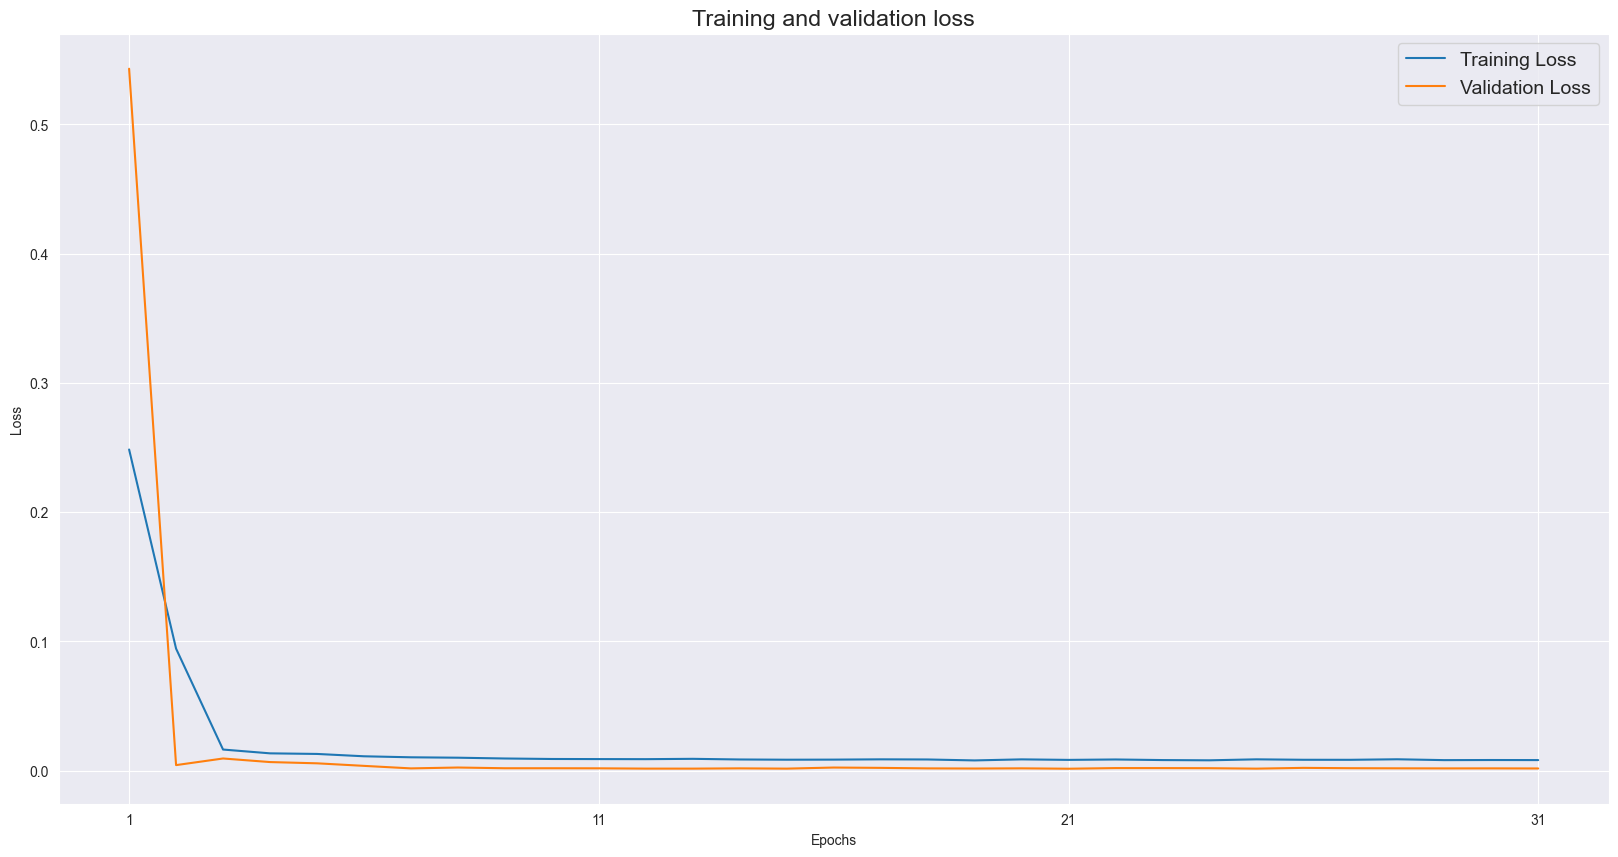

In [40]:
#Showing training and validation loss
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
loss_values50 = loss_values[0:150]
val_loss_values50 = val_loss_values[0:150]
epochs = range(1, len(loss_values50) + 1)
plt.plot(epochs, loss_values50, label='Training Loss')
plt.plot(epochs, val_loss_values50, label='Validation Loss')
plt.rc('font', size = 14)
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.xticks(epochs)
plt.xticks(np.arange(min(epochs), max(epochs)+1, 10.0))
#fig.savefig('test&validationlosscnn.png', dpi=300)
plt.show()

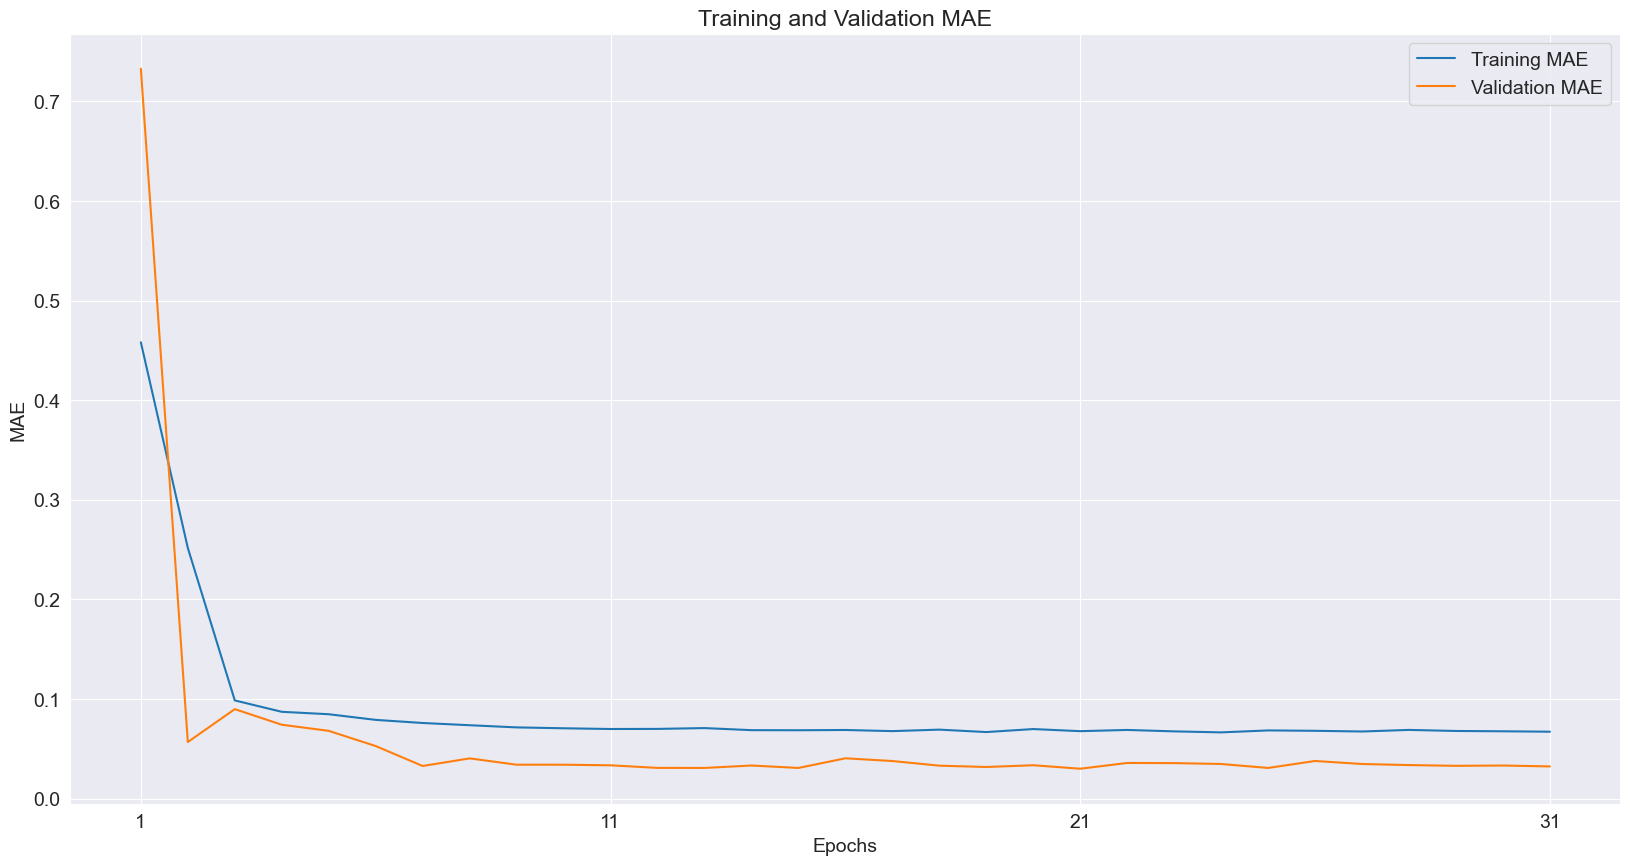

In [41]:
loss_values = history_dict['mae']
val_loss_values = history_dict['val_mae']
loss_values50 = loss_values[0:150]
val_loss_values50 = val_loss_values[0:150]
epochs = range(1, len(loss_values50) + 1)
plt.plot(epochs, loss_values50, label='Training MAE')
plt.plot(epochs, val_loss_values50, label='Validation MAE')
plt.rc('font', size = 14)
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.xticks(epochs)
plt.xticks(np.arange(min(epochs), max(epochs)+1, 10.0))
#fig.savefig('test&validationlosscnn.png', dpi=300)
plt.show()

In [42]:
#Evaluating model
trainScore = model.evaluate(Xtrain, Ytrain, verbose=1)
validScore = model.evaluate(Xvalid, Yvalid, verbose=1)
testScore = model.evaluate(Xtest, Ytest, verbose=1)

23/23 [==============================] - 0s 8ms/step - loss: 0.0028 - mae: 0.0387


In [43]:
testScore, validScore, trainScore

([0.00279597332701087, 0.038718655705451965],
 [0.00144459237344563, 0.029928147792816162],
 [0.0007662707939743996, 0.019822271540760994])

In [44]:
preds = model.predict(Xtest)

23/23 [==============================] - 1s 4ms/step


In [45]:
Xtest.shape

(734, 15, 1)

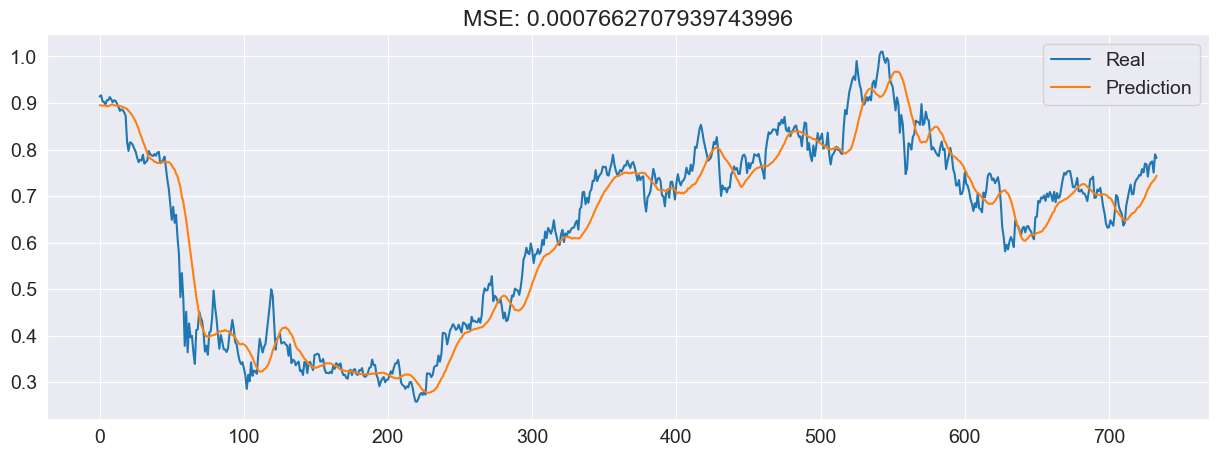

In [46]:

plt.figure(figsize=(15,5))
plt.title('MSE: {}'.format(trainScore[0]))
plt.plot(Ytest, label='Real')
plt.plot(preds, label='Prediction')

plt.legend(loc="best")

#for saving figures
plt.savefig('ScalarGraph.png')
plt.show()

In [47]:
#Show Train and Test Scores
print('Train MSE \t Train RMSE \t Train MAE \t Testscore RMSE \tTest MSE \tTest MAE')
print('%.9f \t %.9f \t %.9f \t %.9f \t \t %.9f \t %.9f' % (trainScore[0], math.sqrt(trainScore[0]),trainScore[1],math.sqrt(testScore[0]),testScore[0],testScore[1]))

Train MSE 	 Train RMSE 	 Train MAE 	 Testscore RMSE 	Test MSE 	Test MAE
0.000766271 	 0.027681597 	 0.019822272 	 0.052876964 	 	 0.002795973 	 0.038718656


In [48]:
#denormalizing datasets
preds = scaler.inverse_transform(preds)
Ytest = scaler.inverse_transform(Ytest)

In [49]:
print('MAE \t\t MAPE')
print('%.4f \t\t %.4f' % (mean_absolute_error(Ytest,preds),(np.mean(np.abs((Ytest - preds) / Ytest)) * 100)))

MAE 		 MAPE
1.9526 		 5.1392
